# CAB420, Metric Learning, Additional Example: Embeddings - Is Bigger Always Better?
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In the previous examples, we've always used an embedding size of $32$. Why? Is this is a good size, or just a number that I picked? This example has a little exploration of that.

In this example, we'll take our triplet network and run that with different embedding sizes.

In [1]:
import random
import numpy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# for consistency
random.seed(4)

## The Data and Helper Functions

The following block is a large copy-paste dump from CAB420_Metric_Learning_Example_3_Triplet_Loss.ipynb. These are the various functions to setup our data, the loss function, and the network building.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None

def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x
    
class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

## The Network

We'll use the same network each time, and just vary the embedding size. As such, we'll create a function for that

In [3]:
def build_network(embedding_size):

    dummy_input = keras.Input((28, 28, 1))
    base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
    embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
    base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

    input_anchor = keras.Input((28, 28, 1), name='Anchor')
    input_positive = keras.Input((28, 28, 1), name='Positive')
    input_negative = keras.Input((28, 28, 1), name='Negative')

    embedding_anchor = base_network(input_anchor)
    embedding_positive = base_network(input_positive)
    embedding_negative = base_network(input_negative)

    margin = 1
    loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer') \
        ([embedding_anchor, embedding_positive, embedding_negative])
    
    triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
    
    return base_network, triplet_network

Setup training parameters so we can easily vary things if we wish to.

In [4]:
batch_size = 128
num_epochs = 20
training_gen = TripleGenerator(x_train, y_train, batch_size)
triplet_test_x = GetTripletData(x_test, y_test, 10000)

And finally a function or two to help evaluate the network.

We're not going to compute accuracies here (which we certainly could do), instead we'll focus on visualising the class separation that we get, so we'll use t-SNE and histograms of distances.

In [5]:
def ComputeDistance(x, y):
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    dist = K.sum(K.square(x - y), axis=-1)
    return dist

def evaluate_network(base_network, x_test, triplet_test_x, y_test):
    embeddings = base_network.predict(x_test)
    tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

    anchor_embedding = base_network.predict(triplet_test_x[0])
    positive_embedding = base_network.predict(triplet_test_x[1])
    negative_embedding = base_network.predict(triplet_test_x[2])

    positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
    negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(positive_distances, numpy.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
    ax.hist(negative_distances, numpy.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
    ax.legend();    

## Embedding Size of 2

We'll start small.

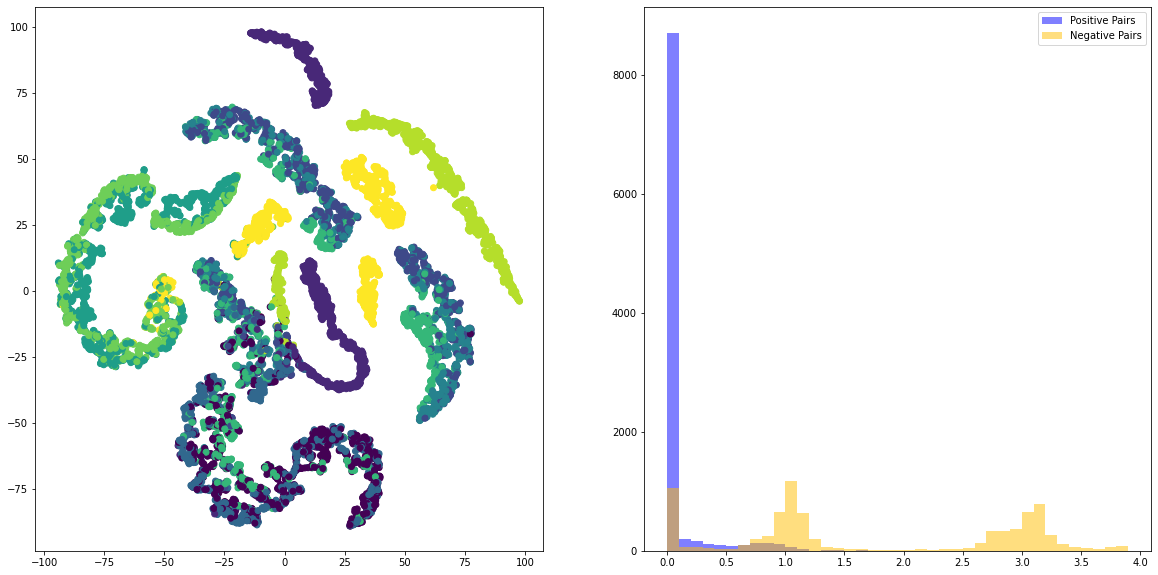

In [6]:
base_network, triplet_network = build_network(2)
triplet_network.compile(optimizer=keras.optimizers.Adam())
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=num_epochs, \
                    validation_data=(triplet_test_x, None), verbose=False)
evaluate_network(base_network, x_test, triplet_test_x, y_test)

With an embedding size of 2, performance is not great. We can see we get poor separation between classes, and our distributions for positive and negative pairs overlap a lot.

## Embedding size of 4

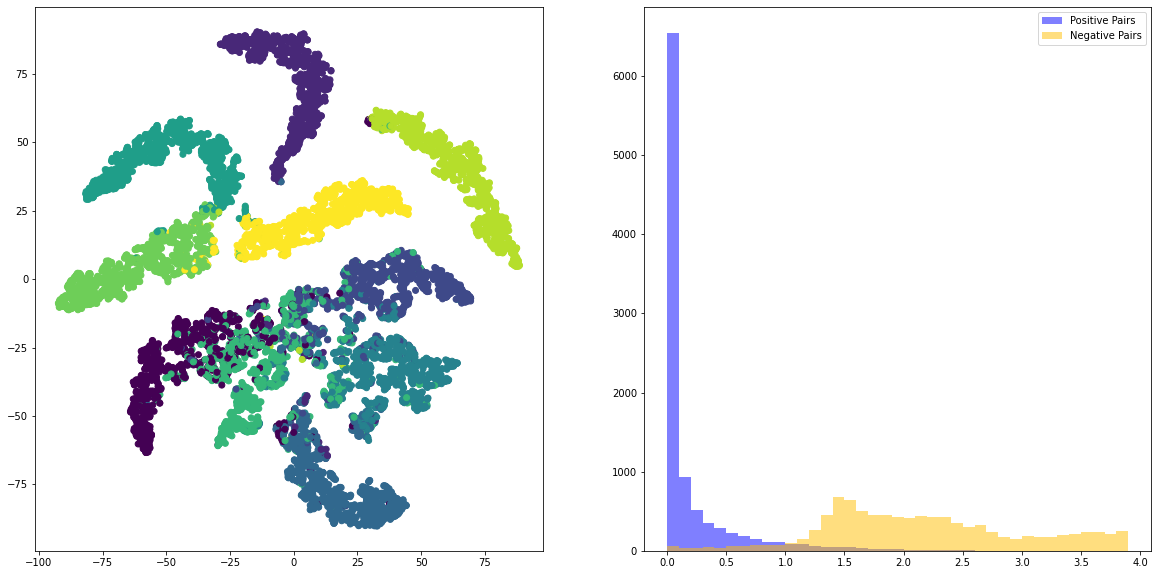

In [7]:
base_network, triplet_network = build_network(4)
triplet_network.compile(optimizer=keras.optimizers.Adam())
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=num_epochs, \
                    validation_data=(triplet_test_x, None), verbose=False)
evaluate_network(base_network, x_test, triplet_test_x, y_test)

The embedding size of four is giving us much better sepration. We still have limited separation between our two distributions, and ther is a fair bit of confusion between some classes, but it's a large improvement.

## Embedding size of 8

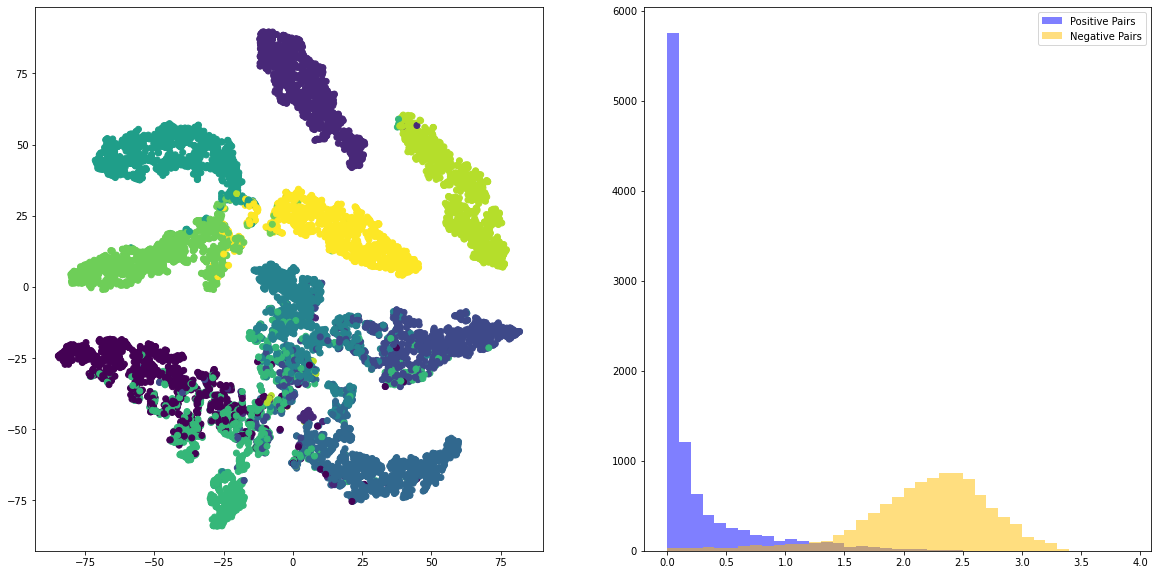

In [8]:
base_network, triplet_network = build_network(8)
triplet_network.compile(optimizer=keras.optimizers.Adam())
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=num_epochs, \
                    validation_data=(triplet_test_x, None), verbose=False)
evaluate_network(base_network, x_test, triplet_test_x, y_test)

Moving to an embedding size of 8 is better again. Class boundaries and the positive and negative distributions are much clearer again.

## Embedding size of 32

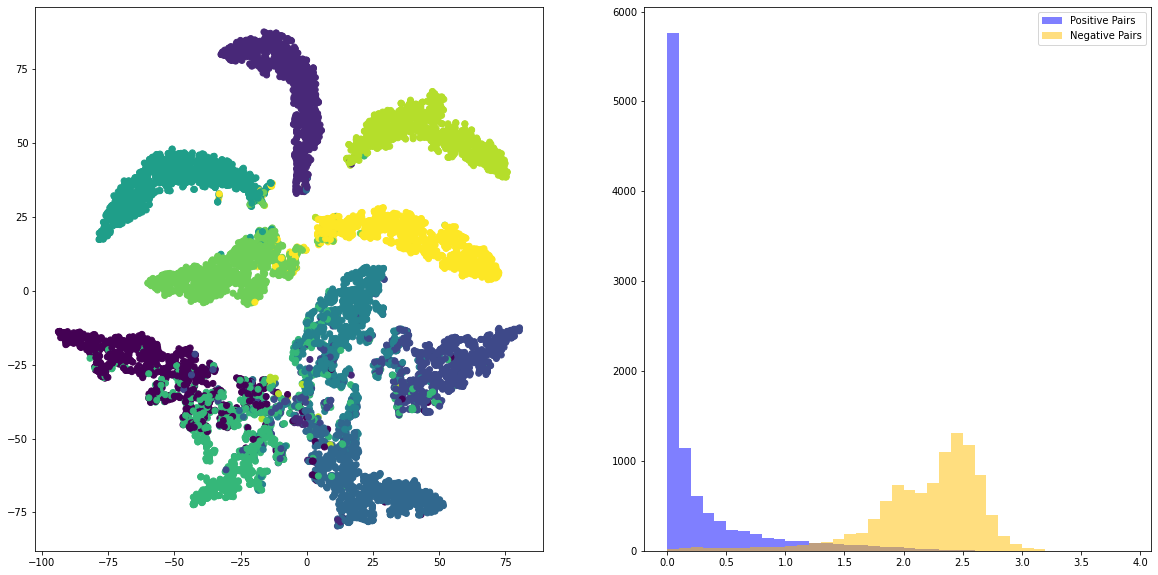

In [9]:
base_network, triplet_network = build_network(32)
triplet_network.compile(optimizer=keras.optimizers.Adam())
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=num_epochs, \
                    validation_data=(triplet_test_x, None), verbose=False)
evaluate_network(base_network, x_test, triplet_test_x, y_test)

At this point, we're starting to see our returns diminish. We're still a bit better off, but compared the jumps in performance we saw with 2 to 4 and 4 to 8, the gain here is much smaller.

## Embedding size of 128

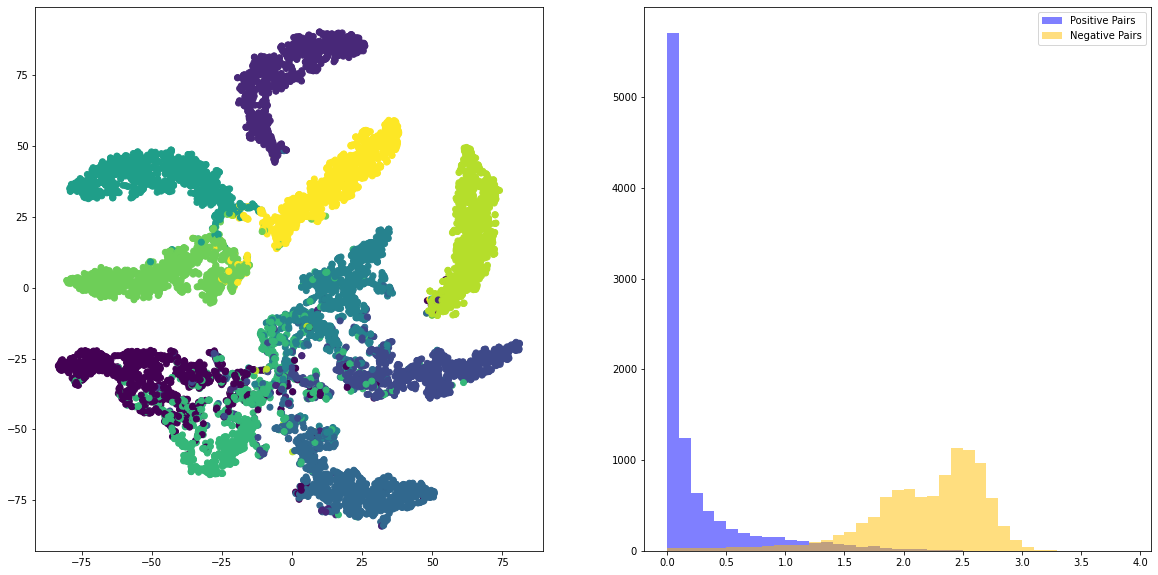

In [10]:
base_network, triplet_network = build_network(128)
triplet_network.compile(optimizer=keras.optimizers.Adam())
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=num_epochs, \
                    validation_data=(triplet_test_x, None), verbose=False)
evaluate_network(base_network, x_test, triplet_test_x, y_test)

At this point, we're seeing a very slight improvement. Training for longer would help this further, but we're still not going to get the same sort of gain we had earlier.

## Final Thoughts

So what have we learned today?

Bigger embeddings do give us more discriminative power - but there is a limit. This limit really comes from two places:
* Our problem. For example, do we really need a massive embedding to tell clothes apart? Problems that are more complex, either though having more classes or by having classes that are easier to confuse will benefit more from larger embedding sizes. 
* Our base network. Does our base network really have the capacity to extract a meaninful embedding of that size? Bigger base networks will give you more meaningful large embeddings.

In our example here, we see that an embedding of 32 is more than enough with our base network and problem. If we increased the complexity of our base network, we'd get more benefit for a larger embedding. Similarly, if we replicated this on for example K-MNIST49, we'd get more benefit from the the larger embedding. Ultimatley, this is (yet another) hyper-parameter to consider during model design.

### Other Embedding Size Considerations

Depending on our end task, we may have other reasons to set the embedding size. Consider a content retrieval problem, i.e. given a piece of data, find other similar pieces of data. In such a problem a common pipeline is:
* For our library of data that we're matching things to, compute a low dimensional representation (i.e. an embedding)
* Given an input sample, map it to the same low dimensional space
* Compare the input sample to the samples stored in the library, retrieving the most relevant

If we consider the computational costs of this pipeline, when we get an input sample the main cost will come from comparing our input to everything in the library of data we're matching to. That cost is linearly proportional to the size of our embedding. If for example we can an embedding of size 128 rather than 1024, that's going to be 8 times faster (and require 8 times less storage to store all the gallery embeddings).

Ultimatley this sort of consideration comes down to the individual problem, and what priority there is for increased speed vs accuracy; however nonetheless these issues will be of genuine concern in a real-world system.